If you lived in first-world countries in the past decades, you are probably fortunate enough to have lived with water heater in your homes, or so I'm told. In Germany, there are seem to be two types of water heater: 1) flow heaters (<i>Durchlauferhitzer</i>), where water will be heated up as it flows out the water tap, or 2) water boiler (<i>Warmwasserspeicher</i>), where warm water is stored in a tank continuously.

Out of curiousity, I want to show in the following simulation the functionality and the power consumption of such water heaters. As a model, I will take the version of a water boiler and we will consider following process. The tank of the water boiler has a volume of $V = 10\,L$. The heating process is electrical with the heat flow $Q$. We will assume that the water is used continuously, meaning the inflow and outflow of the water is constant with $F = 0.15\,\frac{L}{s}$. The temperature of the water outlet should be at $42^\circ{}C$. At the beginning, the tank is already filled with water with the same temperature as the inlet $T_\alpha = 20^\circ{}C$.

#### Nomeclature
| Symbol | |
|---|---|
| $F$ | Water flow rate in $m^3\,s^{-1}$ |
| $V$ | Tank volume in $m^3$ |
| $T$ | Temperature in $K$ |
| $Q$ | Heat flow rate in $W$ |
| $\rho$ | Water density in $kg\,m^{-3}$ |
| $c_p$ | Heat capacity of water in $J\,kg^{-1}\,K^{-1}$ |

# Balance Equation

The first step in simulation is the formation of a model equation. Thus, you should dig up your old lecture notes on the subject of heat and mass transfer and construct the heat balance equation. We will assume an ideal mixing inside the tank, so that the outlet temperature is identical to the temperature at any point inside the tank.

The energy balance states that the changes of energy inside the tank is equal to the amount of energy that goes in and out of the system.

\begin{equation} \label{eq:heatBalance}
    \frac{dU}{dt} = \dot{H}_{\alpha} - \dot{H}_{\omega} + \dot{Q}
\end{equation}

The change in internal energy can be represented as $\frac{dU}{dt} = V\,\rho\,c_v\,\frac{dT_R}{dt}$. Further, we assume that water is incompressible, hence $c_v = c_p$ <cite data-cite="Baehr2013">(Baehr, 2013)</cite>. The enthalpy stream can be described with $\dot{H}_i = F\,\rho\,c_p\,T_i$, With the assumption of ideal mixing, the outflow temperature $T_\omega$ is equal to the temperature of the tank $T_R$. The result is the following first-order ordinary differential equation:

\begin{align} \label{eq:tempOde}
    \frac{d T_R}{dt} = \frac{F}{V}(T_{\alpha} - T_R) + \frac{Q}{V\,\rho\,c_p}
\end{align}

The balance equation gives us an initial-value problem with $T_R(t=0) = T_\alpha$.

# Numerical Methods: Runge-Kutta-Method

Despite the fact that the Equation (\ref{eq:tempOde}) can be analitically solved for a constant heat flow rate $Q$, we will use numerical method the differential equation, the classical Runge-Kutta-Method. Suppose we have the value of $T_{R,i} \equiv y_i$ at a specific time $t_i$, the value of $y(t_{i+1})$ for the time $t_{i+1} = t_i + \Delta{}t$ can be approximated with the weighted sums of the differential itself. With $f(t, y) = \frac{dT_R}{dt}$:

| | | | |
|-|-|-|-|
| $t_1 = t_i$ | $y_1 = y_i$ | $p_1 = f(t_1, y_1)$ | $k_1 = \Delta{}t\,p_1$ |
| $t_2 = t_i + \frac{\Delta{}t}{2}$ | $y_1 = y_i + \frac{k_1}{2}$ | $p_2 = f(t_2, y_2)$ | $k_2 = \Delta{}t\,p_2$ |
| $t_3 = t_i + \frac{\Delta{}t}{2}$ | $y_3 = y_i + \frac{k_2}{2}$ | $p_3 = f(t_3, y_3)$ | $k_3 = \Delta{}t\,p_3$ |
| $t_4 = t_i + \Delta{}t$ | $y_4 = y_i + k_3$ | $p_4 = f(t_4, y_4)$ | $k_4 = \Delta{}t\,p_4$ |

With the value of $y(t_{i+1})$
\begin{align} \label{eq:RungeKutta}
    y(t_{i+1}) = y_i + \frac{k_1 + 2k_2 + 2k_3 + k_4}{6}
\end{align}


# Implementation with Python

It is time to implement the simulation in python. We will also use the numpy library for mathematical computing and matplotlib library for plotting. First, we import these libraries and define the differential equation as a function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

def temperature_ode(t: float, T_R: float, params: dict):
    '''Differential equation of the heat balance'''
    T_in = params['T_in']
    F = params['F']
    V = params['V']
    rho = params['rho']
    c_p = params['c_p']
    Q = params['Q']
    
    return (F/V*(T_in - T_R)) + (Q/(V*rho*c_p))

Next, we define the parameters as python variables. You might have noticed the `params` argument in the `temperature_ode` function. All of the following parameters will be then passed to the function as one dictionary, a data-type in python. I find this method to be quite convenient.

In [2]:
F = 0.15e-3    # m^3 s^-1
V = 0.01       # m^3
T_in = 293.15  # K
T_R = T_in     # K
Q = 600        # W; initial heat flow rate
rho = 997      # kg m^-3
c_p = 4.186    # J kg^-1
T_set = 315.15 # K

dt = 0.1       # s, time step for numerically solving the differential equation

params = {'F': F, 'V': V, 'T_in': T_in, 'T_R': T_R, 'Q': Q, 'rho': rho,
          'c_p': c_p, 'T_set': T_set, 'dt': dt}

In the following function, we define one step of a Runge-Cutta computation.

In [3]:
def runge_kutta_step(fun: callable, t_0: float, y_0: float, dt: float, *args):
    '''Perform one step of classical Runge-Kutta Solver for initial-value problem'''
    
    t_1 = t_0
    y_1 = y_0
    k_1 = dt * fun(t_1, y_1, *args)

    t_2 = t_1 + 0.5*dt
    y_2 = y_1 + 0.5*k_1
    k_2 = dt * fun(t_2, y_2, *args)

    t_3 = t_2
    y_3 = y_1 + 0.5*k_2
    k_3 = dt * fun(t_3, y_3, *args)

    t_4 = t_1 + dt
    y_4 = y_1 + k_3
    k_4 = dt * fun(t_4, y_4, *args)

    t = t_0 + dt
    k = k_1/6 + k_2/3 + k_3/3 + k_4/6
    y = y_0 + k
    
    return (t, y)

And all is now set. We can now start the simulation. As the temperature output of the tank should be $T_\omega = 42^\circ{}C$, we have to calculate the specific heat flow rate needed to reach this end temperature. For this purpose, we will set Equation (\ref{eq:tempOde}) to its stationary state, meaning every time-derivative (in this case $\frac{dT_R}{dt}$) is set to zero. The resulting equation can be solved to the required heat flow rate

\begin{equation}\label{eq:stationaryQ}
    Q = F\,\rho\,c_p\,(T_R - T_{\alpha})
\end{equation}

In [4]:
Q_stat = F*rho*c_p*(T_set - T_in)
params['Q'] = Q_stat

print(f'For an output temperature of {T_set:.2f} K,' \
      f' the required heat flow rate is {Q_stat:.2f} W.')

For an output temperature of 315.15 K, the required heat flow rate is 13.77 W.


Thus we will use this heat flow rate in the simulation. To give an idea, how $T_R$ varies with $Q$, we will also simulate the temperature for different $Q$s.

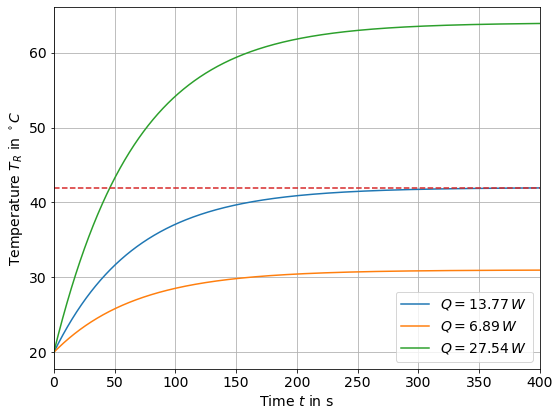

In [5]:
params_1 = params.copy()
params_2 = params.copy()
params_2['Q'] = Q_stat / 2
params_3 = params.copy()
params_3['Q'] = Q_stat * 2

t_start = 0
t_end = 400

time = np.arange(t_start, t_end+dt*0.1, dt)
temp_1 = np.zeros(len(time))
temp_2 = np.zeros(len(time))
temp_3 = np.zeros(len(time))

for idx, t in enumerate(time):
    if idx == 0:
        # Set the initial values
        temp_1[idx] = T_R
        temp_2[idx] = T_R
        temp_3[idx] = T_R
    else:
        _, temp_1[idx] = runge_kutta_step(temperature_ode, t, 
                                          temp_1[idx-1], dt, params_1)
        _, temp_2[idx] = runge_kutta_step(temperature_ode, t, 
                                          temp_2[idx-1], dt, params_2)
        _, temp_3[idx] = runge_kutta_step(temperature_ode, t, 
                                          temp_3[idx-1], dt, params_3)

# Plot result
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, temp_1-273.15, label=f'$Q = {Q_stat:.2f}\,W$')
ax.plot(time, temp_2-273.15, label=f'$Q = {Q_stat/2:.2f}\,W$')
ax.plot(time, temp_3-273.15, label=f'$Q = {Q_stat*2:.2f}\,W$')
ax.plot([min(time), max(time)], [42, 42], '--')
ax.grid('on')
ax.legend()
ax.set_xlabel('Time $t$ in s')
ax.set_ylabel('Temperature $T_R$ in $^\circ{}C$')
ax.set_xlim([time[0], time[-1]])
fig.tight_layout()

And the simulation is done. As you can see, our water heater would need roughly $350\,s$ under the given condition before reaching the desired temperature. You probably wouldn't want to wait so long (especially in the mornings) to get the pleasant warm water. And that is where the concept of control comes in.

# Temperature Control

In the previous figure, we have seen that the stationary outlet temperature $T_R$ depends on the heat input $Q$, where a higher heat rate leads to a higher temperature. If we look at the first 50 seconds, we also see that the higher heat rate results in a faster rise in outlet temperature. Therefore, one idea of control is to change an actuator (in this case the heat flow rate) over the course of time to reach the desired output as quickly as possible.

For our case, we will use a feedback controller with classical tuning rules. As first step, we will take the balance equation:

\begin{align}
    \frac{d T_R}{dt} = \frac{F}{V}(T_{\alpha} - T_R) + \frac{Q}{V\,\rho\,c_p}
\end{align}

and perform a Laplace-Transformation on it. Suppose that 

\begin{align}
\end{align}

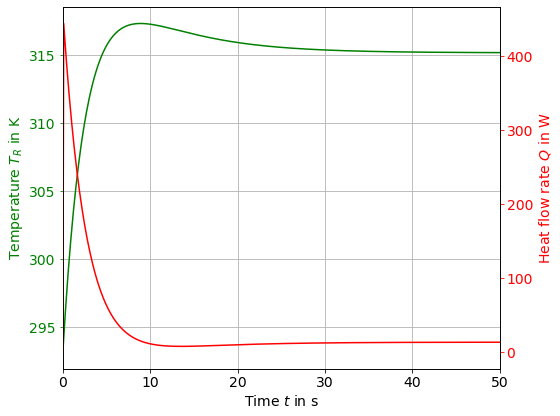

In [6]:
def pi_controller(epsilon, K_P, T_I, dt):
    return K_P * epsilon[-1] + (K_P/T_I)*np.sum(np.multiply(epsilon, dt))

t_end = 50

time = np.arange(0, t_end+dt*0.1, dt)
temp = np.zeros(len(time))
Q = np.zeros(len(time))

K_P = 20
T_I = 10

for idx, t in enumerate(time):
    if idx == 0:
        temp[idx] = T_R
        epsilon = np.array([])
    else:
        epsilon = np.append(epsilon, (T_set - temp[idx-1]))
        Q[idx] = pi_controller(epsilon, K_P, T_I, dt)
        params['Q'] = Q[idx]
        _, temp[idx] = runge_kutta_step(temperature_ode, t, temp[idx-1], dt, params)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, temp, 'g')
ax.grid('on')
ax.set_xlabel('Time $t$ in s')
ax.set_ylabel('Temperature $T_R$ in K')
ax.set_xlim([time[0], time[-1]])
ax.yaxis.label.set_color('g')
ax.tick_params(axis='y', colors='g')

ax2 = ax.twinx()
ax2.plot(time, Q, 'r')
ax2.set_ylabel('Heat flow rate $Q$ in W')
ax2.yaxis.label.set_color('r')
ax2.tick_params(axis='y', colors='r')

fig.tight_layout()

\begin{align}
    \frac{d T_R}{dt} = \frac{F}{V}(T_{\alpha} - T_R) + \frac{Q}{V\,\rho\,c_p}
\end{align}

\begin{align}
    s\,Y(s) = \frac{F}{V}\,T_\alpha - \frac{F}{V}\,Y(s) + \frac{1}{V\,\rho\,c_p}\,U(s)
\end{align}

\begin{align}
    \dot{x} = \begin{pmatrix} 0 & 0 \\ \frac{F}{R} & -\frac{F}{R} \end{pmatrix}\,x + \begin{pmatrix} 0 \\ \frac{1}{V\,\rho\,c_p} \end{pmatrix}\,u \\
    y = \begin{pmatrix} 0 & 1 \end{pmatrix}\,x
\end{align}

In [7]:
import control

A = np.array([[0, 0], [F/V, -F/V]])
B = np.array([[0], [1/(V*rho*c_p)]])
C = np.array([0, 1])
D = 0
sys = control.ss(A, B, C, D)

In [8]:
G = control.ss2tf(sys)

In [9]:
G


 0.02396
---------
s + 0.015

In [10]:
s = control.tf([1, 0], [1])
K = K_P + K_P/(T_I*s)
K


200 s + 20
----------
   10 s

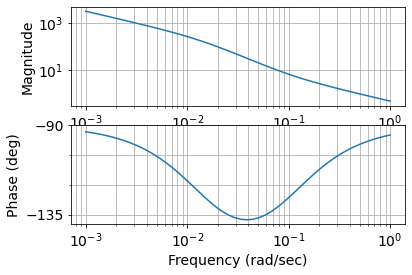

In [11]:
L = K * G
L_bode = control.bode_plot(L)

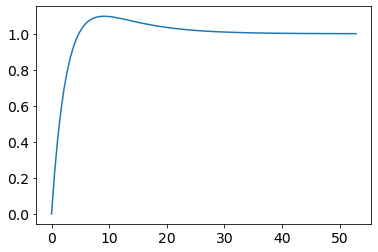

In [12]:
T = L/(1+L)
T_step = control.step_response(T)
plt.plot(T_step[0], T_step[1])

In [13]:
wU = control.tf([20], [1])
M = 1.5
omegaB = 1e2
A = 1e-4
wP = (s/M + omegaB) / (s + omegaB*A)
K = control.mixsyn(G, wP, wU, wU)

In [14]:
K_tf = control.tf(K[0])
K_tf


   9.654e+10 s + 1.448e+09
-----------------------------
s^2 + 6.769e+09 s + 6.769e+07

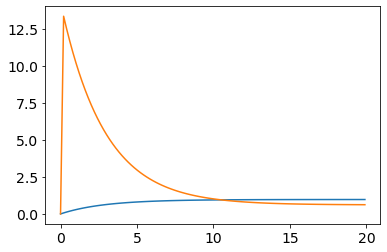

In [15]:
L = K_tf * G
T = L/(1+L)
S = 1 - T
T_step = control.step_response(T)
KS_step = control.step_response(K_tf*S)
plt.plot(T_step[0], T_step[1])
plt.plot(KS_step[0], KS_step[1])

@book{ Baehr2013,
    title = "Wärme- und Stoffübertragung",
    title_sort = "Wärme- und Stoffübertragung",
    author_sort = "Baehr, Hans D. \& Stephan, Karl",
    author = "Hans D. Baehr and Karl Stephan",
    note = "Dieses bereits in dritter Auflage vorliegende Lehrbuch ist eine umfassende und gründliche Darstellung der Wärme- und Stoffübertragung. Ihre Theorie wird systematisch entwickelt, und die Lösungsmethoden aller wichtigen Probleme werden ausführlich behandelt. Daher eignet sich dieses Buch nicht nur für Studenten, sondern nützt auch Wissenschaftlern und Ingenieuren in der Praxis als zuverlässiges Nachschlagewerk. Alle Gebiete der Wärme- und Stoffübertragung werden dargestellt: Wärmeleitung und Diffusion, konvektiver Wärme- und Stoffaustausch, Wärmetransport beim Kondensieren und Verdampfen, die Wärmestrahlung sowie die Berechnung der Wärme- und Stoffübertragung. Zahlreiche durchgerechnete Beispiele sowie Übungsaufgaben und Lösungen erleichtern das Verständnis.
",
    cover = "/Users/felixfebrian/Google Drive/CalibreLibrary/Hans D. Baehr/Warme- und Stoffubertragung (92)/cover.jpg",
    formats = "pdf",
    calibreid = "92",
    isbn = "978-36-6210-835-2",
    library_name = "CalibreLibrary",
    year = "2013",
    month = "Apr",
    publisher = "Springer-Verlag",
    volume = "1",
    size = "21403691 octets",
    tags = "Science, Mechanics, Thermodynamics, Physics, Condensed Matter, Chemistry, Industrial \& Technical, General",
    timestamp = "2020-06-07",
    uuid = "b8143a2c-3266-405c-98fb-7c8aeea95ea8",
    languages = "deu",
    identifiers = "google:QGS0BgAAQBAJ,isbn:9783662108352" }